# SOLUTIONS: Analysis and Classification with Natural Language

In this notebook we will continue with the data we prepared in the last lecture.  Our goals will be to separate the data into positive and negative tweets, compare and analyze them to notice any differences, and then to create a model to classify future tweets as having a positive or negative sentiment.

# Loading Imports

In [157]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.probability import FreqDist
from wordcloud import WordCloud
pd.set_option('display.max_colwidth', None)

# Import Processed Data

We created several versions of our text in the previous lecture.  We will load those again to use for analysis and classification

In [158]:
## Load processed data
df = pd.read_csv('../Data/processed_data.csv')
df.head()

,text,sentiment,length,lower_text,tokens,no_stops,no_stops_no_punct,spacy_lemmas,bigrams
0,"I`d have responded, if I were going",neutral,36,"i`d have responded, if i were going","['i', '`', 'd', 'have', 'responded', ',', 'if', 'i', 'were', 'going']","['`', 'responded', ',', 'going']","['responded', 'going']","['i`d', 'respond', 'go']","[('i`d', 'respond'), ('respond', 'go')]"
1,Sooo SAD I will miss you here in San Diego!!!,negative,46,sooo sad i will miss you here in san diego!!!,"['sooo', 'sad', 'i', 'will', 'miss', 'you', 'here', 'in', 'san', 'diego', '!', '!', '!']","['sooo', 'sad', 'miss', 'san', 'diego', '!', '!', '!']","['sooo', 'sad', 'miss', 'san', 'diego']","['sooo', 'sad', 'miss', 'san', 'diego']","[('sooo', 'sad'), ('sad', 'miss'), ('miss', 'san'), ('san', 'diego')]"
2,my boss is bullying me...,negative,25,my boss is bullying me...,"['my', 'boss', 'is', 'bullying', 'me', '...']","['boss', 'bullying', '...']","['boss', 'bullying', '...']","['boss', 'bully']","[('boss', 'bully')]"
3,what interview! leave me alone,negative,31,what interview! leave me alone,"['what', 'interview', '!', 'leave', 'me', 'alone']","['interview', '!', 'leave', 'alone']","['interview', 'leave', 'alone']","['interview', 'leave']","[('interview', 'leave')]"
4,"Sons of ****, why couldn`t they put them on the releases we already bought",negative,75,"sons of ****, why couldn`t they put them on the releases we already bought","['sons', 'of', '*', '*', '*', '*', ',', 'why', 'couldn', '`', 't', 'they', 'put', 'them', 'on', 'the', 'releases', 'we', 'already', 'bought']","['sons', '*', '*', '*', '*', ',', '`', 'put', 'releases', 'already', 'bought']","['sons', 'put', 'releases', 'already', 'bought']","['son', 'couldn`t', 'release', 'buy']","[('son', 'couldn`t'), ('couldn`t', 'release'), ('release', 'buy')]"


In [159]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27480 entries, 0 to 27479
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   text               27480 non-null  object
 1   sentiment          27480 non-null  object
 2   length             27480 non-null  int64 
 3   lower_text         27480 non-null  object
 4   tokens             27480 non-null  object
 5   no_stops           27480 non-null  object
 6   no_stops_no_punct  27480 non-null  object
 7   spacy_lemmas       27480 non-null  object
 8   bigrams            27480 non-null  object
dtypes: int64(1), object(8)
memory usage: 1.9+ MB


In [160]:
type(df['tokens'][0])

str

## Convert strings of lists to lists

You might recall that pandas interprets lists and strings when importing data.  We can define a quick function to convert them back.

How can we use string methods to do this?

In [161]:
## Function to convert string lists back to lists

def convert_to_list(string):
    """Remove braces, split tokens on commas, and then strip quotes from outside of each token"""
    new_list = [token.strip("' ") for token in string.strip("[]").split(',')]
    return new_list

In [162]:
## applymap function to convert string lists back to lists.

cols = ['tokens','no_stops','no_stops_no_punct', 'spacy_lemmas', 'bigrams']

df[cols] = df[cols].applymap(convert_to_list)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27480 entries, 0 to 27479
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   text               27480 non-null  object
 1   sentiment          27480 non-null  object
 2   length             27480 non-null  int64 
 3   lower_text         27480 non-null  object
 4   tokens             27480 non-null  object
 5   no_stops           27480 non-null  object
 6   no_stops_no_punct  27480 non-null  object
 7   spacy_lemmas       27480 non-null  object
 8   bigrams            27480 non-null  object
dtypes: int64(1), object(8)
memory usage: 1.9+ MB


In [163]:
type(df['tokens'][0])

list

# Class Balance

It's always a good idea to check the class balance when creating a classification model.  This can affect modeling bias and interpretation of metrics.

In [164]:
df['sentiment'].value_counts()

neutral     11117
positive     8582
negative     7781
Name: sentiment, dtype: int64

There are more neutral tweets any any other class, but positive and negative tweets are pretty balanced.

# Length

One easy way to compare text is to compare the length of each text.  We could compare the number of character or tokens.  In this case we will compare the number of characters in each tweet for each sentiment.

The median positive tweet is 67.0 characters long while the median negative tweet is 66.0 long


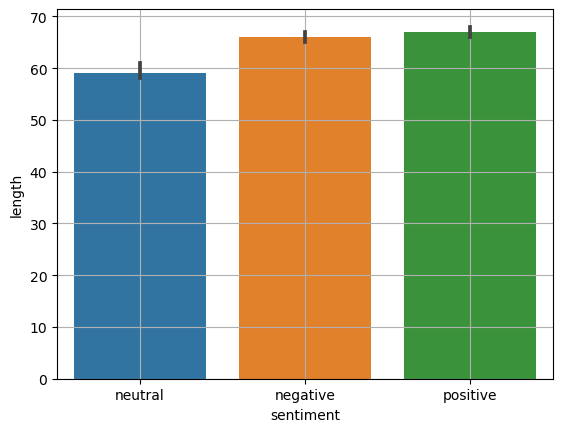

In [165]:
## visualize median tweet length
pos_len = positive['length'].median()
neg_len = negative['length'].median()

print(f'The median positive tweet is {pos_len} characters long while the median negative tweet is {neg_len} long')
sns.barplot(data=df, x='sentiment', y='length', estimator='median')
plt.grid()

We aren't seeing a big difference here in the lengths of tweets.  Both positive and negative seem to averag about 70 characters.  Neutral tweets seem to be somewhat shorter on average.

# Divide by Sentiment

Since we want to compare and classify positive vs negative tweets, we will create 2 different datasets: One of positive tweets and one of negative tweets.  We will not use the neutral tweets for this lecture.

In [166]:
## Divide documents by sentiment
positive = df.loc[df['sentiment'] == 'positive']
negative = df.loc[df['sentiment'] == 'negative']
print('Positive Tweets')
display(positive.head())
print('Negative Tweets')
display(negative.head())

Positive Tweets


,text,sentiment,length,lower_text,tokens,no_stops,no_stops_no_punct,spacy_lemmas,bigrams
6,2am feedings for the baby are fun when he is all smiles and coos,positive,64,2am feedings for the baby are fun when he is all smiles and coos,"[2am, feedings, for, the, baby, are, fun, when, he, is, all, smiles, and, coos]","[2am, feedings, baby, fun, smiles, coos]","[2am, feedings, baby, fun, smiles, coos]","[2, feeding, baby, fun, smile, coo]","[('2, feeding'), ('feeding, baby'), ('baby, fun'), ('fun, smile'), ('smile, coo')]"
9,Journey!? Wow... u just became cooler. hehe... (is that possible!?),positive,69,journey!? wow... u just became cooler. hehe... (is that possible!?),"[journey, !, ?, wow, ..., u, just, became, cooler, ., hehe, ..., (, is, that, possible, !, ?, )]","[journey, !, ?, wow, ..., u, became, cooler, ., hehe, ..., (, possible, !, ?, )]","[journey, wow, ..., u, became, cooler, hehe, ..., possible]","[journey, wow, u, cool, hehe, possible]","[('journey, wow'), ('wow, u'), ('u, cool'), ('cool, hehe'), ('hehe, possible')]"
11,I really really like the song Love Story by Taylor Swift,positive,56,i really really like the song love story by taylor swift,"[i, really, really, like, the, song, love, story, by, taylor, swift]","[really, really, like, song, love, story, taylor, swift]","[really, really, like, song, love, story, taylor, swift]","[like, song, love, story, taylor, swift]","[('like, song'), ('song, love'), ('love, story'), ('story, taylor'), ('taylor, swift')]"
21,Playing Ghost Online is really interesting. The new updates are Kirin pet and Metamorph for third job. Can`t wait to have a dragon pet,positive,135,playing ghost online is really interesting. the new updates are kirin pet and metamorph for third job. can`t wait to have a dragon pet,"[playing, ghost, online, is, really, interesting, ., the, new, updates, are, kirin, pet, and, metamorph, for, third, job, ., can, `, t, wait, to, have, a, dragon, pet]","[playing, ghost, online, really, interesting, ., new, updates, kirin, pet, metamorph, third, job, ., `, wait, dragon, pet]","[playing, ghost, online, really, interesting, new, updates, kirin, pet, metamorph, third, job, wait, dragon, pet]","[play, ghost, online, interesting, new, update, kirin, pet, metamorph, job, can`t, wait, dragon, pet]","[('play, ghost'), ('ghost, online'), ('online, interesting'), ('interesting, new'), ('new, update'), ('update, kirin'), ('kirin, pet'), ('pet, metamorph'), ('metamorph, job'), ('job, can`t'), ('can`t, wait'), ('wait, dragon'), ('dragon, pet')]"
25,"the free fillin` app on my ipod is fun, im addicted",positive,51,"the free fillin` app on my ipod is fun, im addicted","[the, free, fillin, `, app, on, my, ipod, is, fun, , , im, addicted]","[free, fillin, `, app, ipod, fun, , , im, addicted]","[free, fillin, app, ipod, fun, im, addicted]","[free, fillin, `, app, ipod, fun, m, addicted]","[('free, fillin'), ('fillin, `'), ('`, app'), ('app, ipod'), ('ipod, fun'), ('fun, m'), ('m, addicted')]"


Negative Tweets


,text,sentiment,length,lower_text,tokens,no_stops,no_stops_no_punct,spacy_lemmas,bigrams
1,Sooo SAD I will miss you here in San Diego!!!,negative,46,sooo sad i will miss you here in san diego!!!,"[sooo, sad, i, will, miss, you, here, in, san, diego, !, !, !]","[sooo, sad, miss, san, diego, !, !, !]","[sooo, sad, miss, san, diego]","[sooo, sad, miss, san, diego]","[('sooo, sad'), ('sad, miss'), ('miss, san'), ('san, diego')]"
2,my boss is bullying me...,negative,25,my boss is bullying me...,"[my, boss, is, bullying, me, ...]","[boss, bullying, ...]","[boss, bullying, ...]","[boss, bully]","[('boss, bully')]"
3,what interview! leave me alone,negative,31,what interview! leave me alone,"[what, interview, !, leave, me, alone]","[interview, !, leave, alone]","[interview, leave, alone]","[interview, leave]","[('interview, leave')]"
4,"Sons of ****, why couldn`t they put them on the releases we already bought",negative,75,"sons of ****, why couldn`t they put them on the releases we already bought","[sons, of, *, *, *, *, , , why, couldn, `, t, they, put, them, on, the, releases, we, already, bought]","[sons, *, *, *, *, , , `, put, releases, already, bought]","[sons, put, releases, already, bought]","[son, couldn`t, release, buy]","[('son, couldn`t'), ('couldn`t, release'), ('release, buy')]"
12,My Sharpie is running DANGERously low on ink,negative,44,my sharpie is running dangerously low on ink,"[my, sharpie, is, running, dangerously, low, on, ink]","[sharpie, running, dangerously, low, ink]","[sharpie, running, dangerously, low, ink]","[sharpie, run, dangerously, low, ink]","[('sharpie, run'), ('run, dangerously'), ('dangerously, low'), ('low, ink')]"


# Frequency Distribution

Let's take a look at how often different words appear in the tweets.  

The NLTK FreqDist class expects a list of all tokens in all documents.  We can create this with the `.explode()` method to create new rows for every word.  We can then convert the resulting series to a list with `to_list()` to pass to the `FreqDist` class constructor.

In [167]:
## Create list of all tokens in all documents
pos_words = positive['tokens'].explode().to_list()
neg_words = negative['tokens'].explode().to_list()
pos_words[:10]

['2am', 'feedings', 'for', 'the', 'baby', 'are', 'fun', 'when', 'he', 'is']

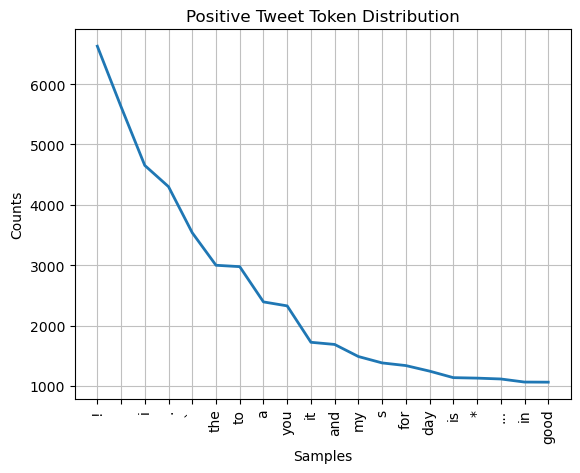

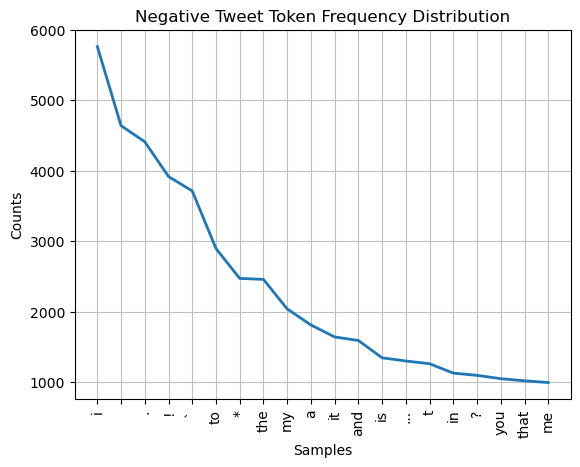

In [168]:
## Instantiate positive frequency distribution
pos_freq_dist = FreqDist(pos_words)
neg_freq_dist = FreqDist(neg_words)

## Plot the distribution
pos_freq_dist.plot(20, title='Positive Tweet Token Distribution')

neg_freq_dist.plot(20, title='Negative Tweet Token Frequency Distribution');

We can see already that punctuation and very common words are at the top of both lists.  To avoid this, we can use our normalized data instead.  Let's use our lemmas!

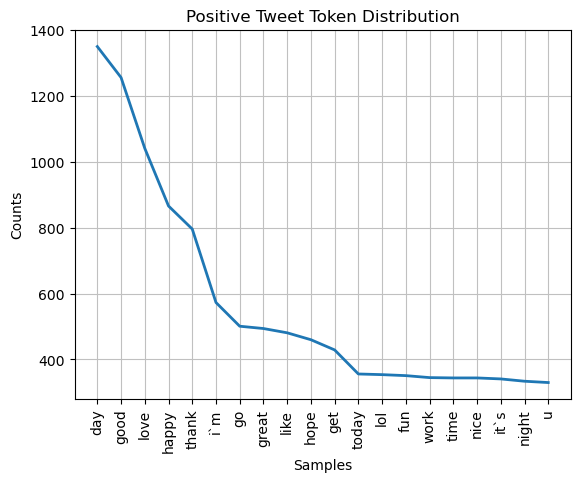

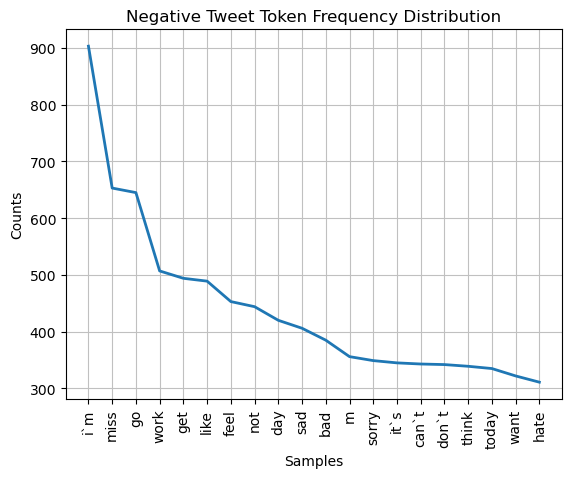

In [169]:
## Create list of all tokens in all documents
pos_words = positive['spacy_lemmas'].explode().to_list()
neg_words = negative['spacy_lemmas'].explode().to_list()

## Instantiate positive frequency distribution
pos_freq_dist = FreqDist(pos_words)
neg_freq_dist = FreqDist(neg_words)

## Plot the distribution
pos_freq_dist.plot(20, title='Positive Tweet Token Distribution')

neg_freq_dist.plot(20, title='Negative Tweet Token Frequency Distribution');

These are more informative!  We see words like 'good', 'love', 'hope', 'great', and 'nice' in the positives and 'miss', 'work', 'sad', 'bad', and 'hate' in negatives.

While this may not be surprising with positive and negative sentiments, if we were classifying other kinds of text, like spam emails or patent applications, it could be very enlightening!

# Word Clouds

Word Clouds tell us the same kinds of things as a frequency distribution, but are a nice way to visualize.  They can be used for project headers or presentations.

The `WordCloud` class expects texts to be one long string, so.  We will use our lemmas again, so we have to join all the tokens for each document into one long string.

## Processing the data for WordCloud

WordCloud expects one single string of all the words in a corpus.  since we already have a list of all the words, for each sentiment, we can just join those.

In [170]:
## Join the words for each sentiment
all_pos_lemmas = ' '.join(pos_words)
all_neg_lemmas = ' '.join(neg_words)
type(all_pos_lemmas)

str

## Creating and displaying the Word Clouds

We will create the clouds and generate the images below.  We want to focus on larger words, otherwise we get some strange results due to contractions.  We will tell WordCloud to only generate words with 2 or more letters.

(-0.5, 399.5, 199.5, -0.5)

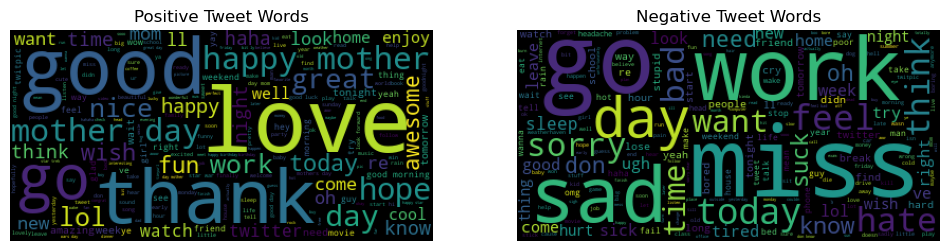

In [171]:
## Generate the WordCloud Images
pos_cloud = WordCloud(min_word_length=2).generate(all_pos_lemmas)
neg_cloud = WordCloud(min_word_length=2).generate(all_neg_lemmas)

## Plot the Images

fig, axes = plt.subplots(ncols=2, figsize=(12, 6))
axes[0].imshow(pos_cloud)
axes[0].set_title('Positive Tweet Words')
axes[0].axis('off')

axes[1].imshow(neg_cloud)
axes[1].set_title('Negative Tweet Words')
axes[1].axis('off')



This can be a fun way to help you stakeholders get a feel for the token distributions in our data.

# N-gram Analysis

We can do something similar with ngrams.  NLTK has native classes for finding and measuring the frequency of ngrams as well.

For this we need 2 objects: a measures class depending on the measure we want to see and a finder class based on the number of words in our ngram.

These classes exist for bi, tri, and quadgrams, but we will just focus on bigrams.

## Calcuate Frequency Scores

In [172]:
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder

## Create measure classes
measures = BigramAssocMeasures()

## Create collector classes
pos_finder = BigramCollocationFinder.from_words(pos_words)
neg_finder = BigramCollocationFinder.from_words(neg_words)

In [173]:
## Calculate positive and negative ngram scores
pos_scores = pos_finder.score_ngrams(measures.raw_freq)
pos_ngram_scores = pd.DataFrame(pos_scores, columns=['positive ngram', 'positive score'])

neg_scores = neg_finder.score_ngrams(measures.raw_freq)
neg_ngram_scores = pd.DataFrame(neg_scores, columns=['negative ngram', 'negative score'])

## Display the frequency scores
display(pos_ngram_scores.head(20))
display(neg_ngram_scores.head(20))

,positive ngram,positive score
0,"(mother`s, day)",0.005103
1,"(happy, mother`s)",0.004220
2,"(good, morning)",0.002339
3,"(mother, day)",0.001996
4,"(mothers, day)",0.001750
5,"(go, to)",0.001652
6,"(happy, mother)",0.001554
7,"(happy, mothers)",0.001554
8,"(can`t, wait)",0.001276
9,"(good, luck)",0.001194


,negative ngram,negative score
0,"(go, to)",0.003087
1,"(feel, like)",0.001911
2,"(i`m, go)",0.001507
3,"(i`m, sorry)",0.001268
4,"(look, like)",0.001066
5,"(don`t, know)",0.000845
6,"(will, not)",0.000772
7,"(feel, bad)",0.000753
8,"(sorry, hear)",0.000753
9,"(don`t, like)",0.000680


## Plot Frequency Scores

<Axes: title={'center': 'Negative Ngram Frequency'}, xlabel='negative ngram'>

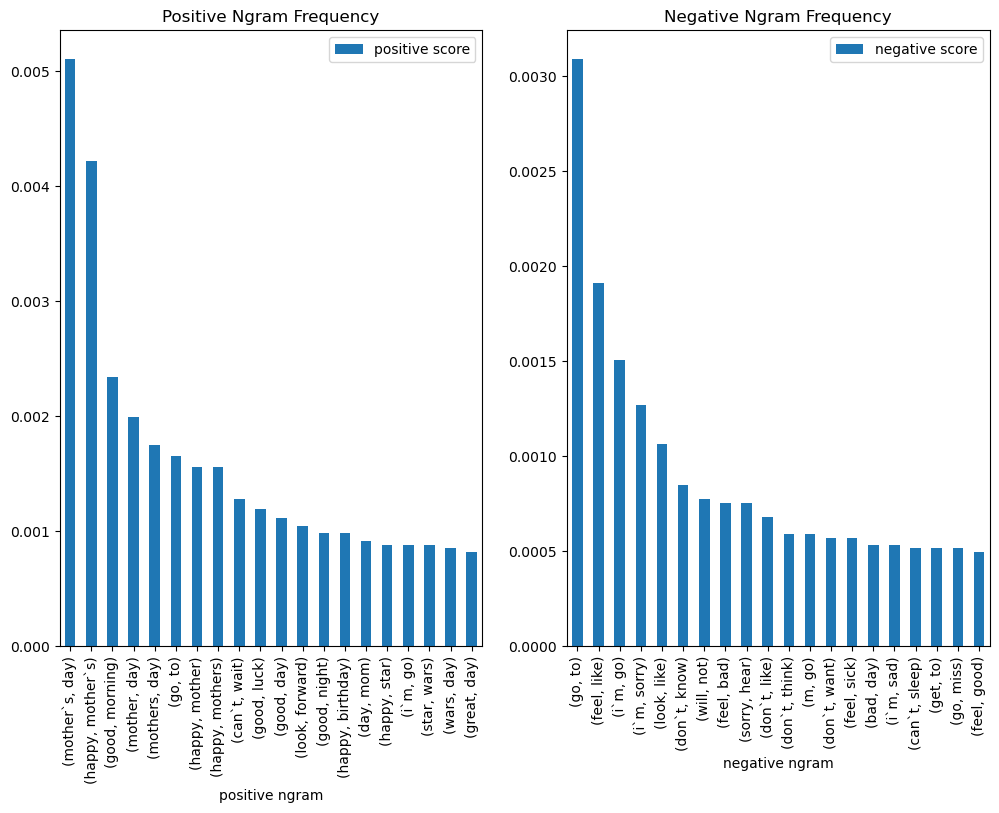

In [174]:
## Create a figure and axes
fig, axes = plt.subplots(1,2, figsize=(12,8))

## Plot the ngram frequencies
pos_ngram_scores.head(20).plot(x='positive ngram', kind='bar', title='Positive Ngram Frequency',
                                        ax=axes[0])
neg_ngram_scores.head(20).plot(x='negative ngram', kind='bar', title='Negative Ngram Frequency',
                                        ax=axes[1])

This might be more enlightening than the individual word frequency counts.  There are some relatable bigrams here.

We are also seeing a lot of versions of 'happy mother's day' which may tell us that more normalization is required here.  This would be a consideration in longer term projects.

# Preparing Data for Modeling

In this lesson we will be using a Bag of Words approach to modeling.  This means our final features will be just the counts of how many times each word appears in each document.  

We have many versions of our data to choose from for modeling.  Our lemmas are probably the most normalized, but our raw tokens have the most information.  The others are somewhere in between.  In this notebook we will be using the lemmatized data.  

We will try both the CountVectorizer and TfidfVectorizer for vectorization.  Both create a column for every word in the vocabulary.

**CountVectorizer** adds the raw counts of each word for each document.  It can be very sensitive to stop words, so we want to be sure to 

**TfidifVectorizer** adds a value that represents how unique the word is to the document, compared to all other documents in the corpus.  The more times a word appears in a document and the fewer times it appears in other documents the higher the value will be for that word.

Both of these vectorizers assume that documents will be single strings.  We will join our lemmas together again.

In [180]:
## Import Modeling Packages
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV

## Validation Split

We will perform a triple split.  That way we can tune our model to a validation set and test the final version on a test set.  This avoid tuning our model to specifically perform well on just one set of testing data and gives us a better idea of how our model will perform on new data.

In [177]:
def join_tokens(token_list):
    joined_tokens = ' '.join(token_list)
    return joined_tokens

X = df['spacy_lemmas'].apply(join_tokens)
y = df['sentiment']
X.head()

0              i`d respond go
1     sooo sad miss san diego
2                  boss bully
3             interview leave
4    son couldn`t release buy
Name: spacy_lemmas, dtype: object

In [179]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=.3, random_state=42)
X_train.head()

21911                                       morning load 2day goin walk 1st rid nite haribo`
24540                                                 know it`s sprain it` repetitive injury
26262                bestie twitpic http://twitpic.com/67hac bestie http://twitpic.com/67hac
22393                                                                       check work sorry
27322    u guy say california angry tweet perez hilton jonathan upset spell california wrong
Name: spacy_lemmas, dtype: object

Here we see more opportunities for normalization.  In future iterations we could use RegEx to remove the web links or email addresses.

## Modeling

We are going to use a Multinomial Naive Bayes model.  Bayesian models have been shown to often perform well with text data.  However, we could use any classification model we wanted to.